In [1]:
pip install magent2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 61.1 MB/s eta 0:00:00


In [2]:
pip install pettingzoo==1.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.4/823.4 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: pettingzoo
    Found existing installation: pettingzoo 1.24.3
    Uninstalling pettingzoo-1.24.3:
      Successfully uninstalled pettingzoo-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
magent2 0.3.3 requires pettingzoo>=1.23.1, but you have pettingzoo 1.22.0 which is incompatible.


In [3]:
!git clone https://github.com/angWindy/Reinforcement-Learning-Final-Project.git

Cloning into 'Reinforcement-Learning-Final-Project'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 104 (delta 32), reused 68 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 18.60 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from magent2.environments import battle_v4
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
from collections import deque
import random

# --- Dueling Q-Network ---
class DuelingQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1).unsqueeze(0)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]

        self.fc_value = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 1)
        )

        self.fc_advantage = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, action_shape)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.cnn(x)
        x = x.reshape(x.size(0), -1)
        value = self.fc_value(x)
        advantage = self.fc_advantage(x)
        return value + advantage - advantage.mean(dim=1, keepdim=True)

In [5]:
# --- Prioritized Replay Buffer ---
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        self.pos = 0
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        beta = self.beta_start + (1.0 - self.beta_start) * self.frame / self.beta_frames
        self.frame = min(self.frame + 1, self.beta_frames)

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        state, action, reward, next_state, done = zip(*samples)
        return state, action, reward, next_state, done, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio
            self.max_priority = max(self.max_priority, prio)

    def __len__(self):
        return len(self.buffer)


In [6]:
# --- Function to evaluate a checkpoint ---
def evaluate_checkpoint(q_network, num_episodes=5):
    env = battle_v4.parallel_env(map_size=45, max_cycles=1000, minimap_mode=False)
    total_steps = 0
    total_rewards = 0
    for _ in range(num_episodes):
        observations = env.reset()
        done_agents = set()
        steps = 0
        episode_reward = 0
        while True:
            actions = {}
            red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
            blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

            if red_agents:
                states_red = torch.stack([
                    torch.tensor(observations[agent], dtype=torch.float32)
                    for agent in red_agents
                ]).to(device)
                with torch.no_grad():
                    q_values_red = q_network(states_red)
                    selected_actions_red = torch.argmax(q_values_red, dim=1)

                for idx, agent in enumerate(red_agents):
                    actions[agent] = selected_actions_red[idx].item()

            if blue_agents:
                for idx, agent in enumerate(blue_agents):
                  actions[agent] = env.action_spaces[agent].sample()

            next_obs, rewards, terminations, truncations, infos = env.step(actions)

            # Update done_agents based on terminations
            done_agents.update([agent for agent, terminated in terminations.items() if terminated])

            observations = next_obs
            steps += 1

            episode_reward += sum(rewards.get(agent, 0.0) for agent in red_agents)

            # Check if all agents are done (either terminated or truncated)
            if all(terminations.values()) or all(truncations.values()):
                total_steps += steps
                total_rewards += episode_reward
                break
    return total_steps / num_episodes, total_rewards / num_episodes


In [13]:
# --- Initialize environment and device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- TensorBoard writer ---
log_dir = os.path.join("runs", "Dueling_DDQN_BattleV4_PER_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)

# --- Initialize the environment ---
env = battle_v4.parallel_env(map_size=45, max_cycles=1000, minimap_mode=False)

sample_observation = env.observation_spaces[env.agents[0]].shape
state_space = sample_observation
action_space = env.action_spaces[env.agents[0]].n

# --- Initialize networks and optimizers ---
q_network_red = DuelingQNetwork(state_space, action_space).to(device)
target_network_red = DuelingQNetwork(state_space, action_space).to(device)
target_network_red.load_state_dict(q_network_red.state_dict())
target_network_red.eval()

optimizer_red = optim.Adam(q_network_red.parameters(), lr=0.0005)

# --- Hyperparameters ---
epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.15
gamma = 0.99
num_episodes = 200
max_steps_per_episode = 1000
checkpoint_interval = 5
polyak_tau = 0.005
replay_buffer_size = 100000
batch_size = 128
num_val_episodes = 5

# --- Initialize prioritized replay buffers ---
replay_buffer_red = PrioritizedReplayBuffer(replay_buffer_size)
# --- Training loop ---
best_val = float('inf')
best_checkpoint = ""
for episode in range(0, num_episodes + 1):
    observations = env.reset()
    total_reward_red = 0
    done_agents = set()

    for step in range(max_steps_per_episode):
        actions = {}
        red_agents = [agent for agent in env.agents if agent.startswith("red_") and agent not in done_agents]
        blue_agents = [agent for agent in env.agents if agent.startswith("blue_") and agent not in done_agents]

        # --- Process all red agents ---
        if red_agents:
            states_red = torch.stack([
                torch.tensor(observations[agent], dtype=torch.float32)
                for agent in red_agents
            ]).to(device)

            # --- Select actions ---
            if np.random.random() < epsilon:
                selected_actions_red = torch.randint(0, action_space, (len(red_agents),), device=device)
            else:
                with torch.no_grad():
                    q_values_red = q_network_red(states_red)
                    selected_actions_red = torch.argmax(q_values_red, dim=1)

            for idx, agent in enumerate(red_agents):
                actions[agent] = selected_actions_red[idx].item()

        # --- Process all blue agents ---
        if blue_agents:
            selected_actions_blue = torch.randint(0, action_space, (len(blue_agents),), device=device)
            for idx, agent in enumerate(blue_agents):
                actions[agent] = selected_actions_blue[idx].item()

        # --- Take step in environment ---

        next_obs, rewards, terminations, truncations, infos = env.step(actions)
        # --- Update total rewards ---
        total_reward_red += sum(rewards.get(agent, 0.0) for agent in red_agents)

        for agent in red_agents:
            # Handle cases where next_obs might not be available for done agents
            next_state = next_obs.get(agent) if not terminations.get(agent, False) else observations[agent]  # Use current state as next state if agent is done

            replay_buffer_red.push(
                observations[agent],
                actions[agent],
                rewards.get(agent, 0.0),
                next_state,
                terminations.get(agent, False)  # Only consider termination as done
            )

        # --- Update done_agents based on terminations ---
        done_agents.update([agent for agent, terminated in terminations.items() if terminated])

        # --- Train red network on a batch sampled from replay buffer ---
        if len(replay_buffer_red) >= batch_size:
            state_batch, action_batch, reward_batch, next_state_batch, done_batch, indices, weights = replay_buffer_red.sample(batch_size)

            current_states_red = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
            current_actions_red = torch.tensor(action_batch, dtype=torch.long).unsqueeze(1).to(device)
            next_states_red = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
            rewards_red = torch.tensor(reward_batch, dtype=torch.float32).unsqueeze(1).to(device)
            dones_red = torch.tensor(done_batch, dtype=torch.float32).unsqueeze(1).to(device)
            weights_tensor_red = torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(device)

            current_q_values_red = q_network_red(current_states_red).gather(1, current_actions_red)
            with torch.no_grad():
                actions = q_network_red(next_states_red).max(1, keepdim=True)[1]
                next_q_values_red = target_network_red(next_states_red).gather(1, actions)
                target_q_values_red = rewards_red + gamma * next_q_values_red * (1 - dones_red)

            td_errors = (target_q_values_red - current_q_values_red).abs().detach().cpu().numpy()
            new_priorities = td_errors + 1e-6
            replay_buffer_red.update_priorities(indices, new_priorities)

            loss_red = (weights_tensor_red * nn.SmoothL1Loss(reduction='none')(current_q_values_red, target_q_values_red)).mean()

            optimizer_red.zero_grad()
            loss_red.backward()
            nn.utils.clip_grad_norm_(q_network_red.parameters(), 1.0)
            optimizer_red.step()

            writer.add_scalar('Loss/Red', loss_red.item(), episode * max_steps_per_episode + step)

        # --- Soft update target networks ---
        for target_param, param in zip(target_network_red.parameters(), q_network_red.parameters()):
            target_param.data.copy_(polyak_tau * param.data + (1 - polyak_tau) * target_param.data)

        observations = next_obs

        # Check for episode termination (either all terminated or max_cycles reached)
        if all(terminations.values()) or (truncations and all(truncations.values())):
            break

    # --- Update epsilon ---
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    # --- Log episode statistics ---
    writer.add_scalar('Total Reward/Red', total_reward_red, episode)
    writer.add_scalar('Epsilon', epsilon, episode)
    print(f"Episode {episode}/{num_episodes}, Total Reward Red: {total_reward_red:.2f}, "
          f"Epsilon: {epsilon:.2f}")

    # --- Save checkpoints and evaluate ---
    if episode % checkpoint_interval == 0:
        checkpoint_path = f"red_agent_dueling_ddqn_per_ep{episode}.pth"
        torch.save(q_network_red.state_dict(), checkpoint_path)
        val, val_reward = evaluate_checkpoint(q_network_red, num_val_episodes)
        writer.add_scalar('Validation/Average Steps', val, episode)
        writer.add_scalar('Validation/Average Reward', val_reward, episode)
        print(f"Episode {episode}: Validation average steps = {val:.2f}, Validation average reward = {val_reward:.2f}")
        if val <= best_val:
            best_val = val
            if best_checkpoint:
                os.remove(best_checkpoint)
            print(f"New best checkpoint saved at {best_checkpoint} with average steps {best_val:.2f}")
        if val > best_val:
            os.remove(checkpoint_path)
if best_checkpoint:
    best_checkpoint_final = "red_agent_dueling_noisy_ddqn_per_best.pth"
    os.rename(best_checkpoint, best_checkpoint_final)
    print(f"Training complete. Best model saved at {best_checkpoint_final}")
else:
    torch.save(q_network_red.state_dict(), "red_agent_dueling_noisy_ddqn_per_final.pth")
    print(f"Training complete. Final model saved at red_agent_dueling_noisy_ddqn_per_final.pth")

Using device: cuda


<ipython-input-5-87dcd35cb4c7>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = prio
<ipython-input-5-87dcd35cb4c7>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.pos] = self.max_priority


Episode 0/200, Total Reward Red: -3249.67, Epsilon: 0.99
Episode 0: Validation average steps = 1000.00, Validation average reward = -263.20
New best checkpoint saved at red_agent_dueling_ddqn_per_ep0.pth with average steps 1000.00
Episode 1/200, Total Reward Red: -3246.10, Epsilon: 0.98
Episode 2/200, Total Reward Red: -3166.14, Epsilon: 0.97
Episode 3/200, Total Reward Red: -2987.69, Epsilon: 0.96
Episode 4/200, Total Reward Red: -2878.15, Epsilon: 0.95
Episode 5/200, Total Reward Red: -2811.36, Epsilon: 0.94
Episode 5: Validation average steps = 129.80, Validation average reward = 378.29
New best checkpoint saved at red_agent_dueling_ddqn_per_ep5.pth with average steps 129.80
Episode 6/200, Total Reward Red: -2717.80, Epsilon: 0.93
Episode 7/200, Total Reward Red: -2785.20, Epsilon: 0.92
Episode 8/200, Total Reward Red: -2686.00, Epsilon: 0.91
Episode 9/200, Total Reward Red: -2681.40, Epsilon: 0.90
Episode 10/200, Total Reward Red: -1856.45, Epsilon: 0.90
Episode 10: Validation aver

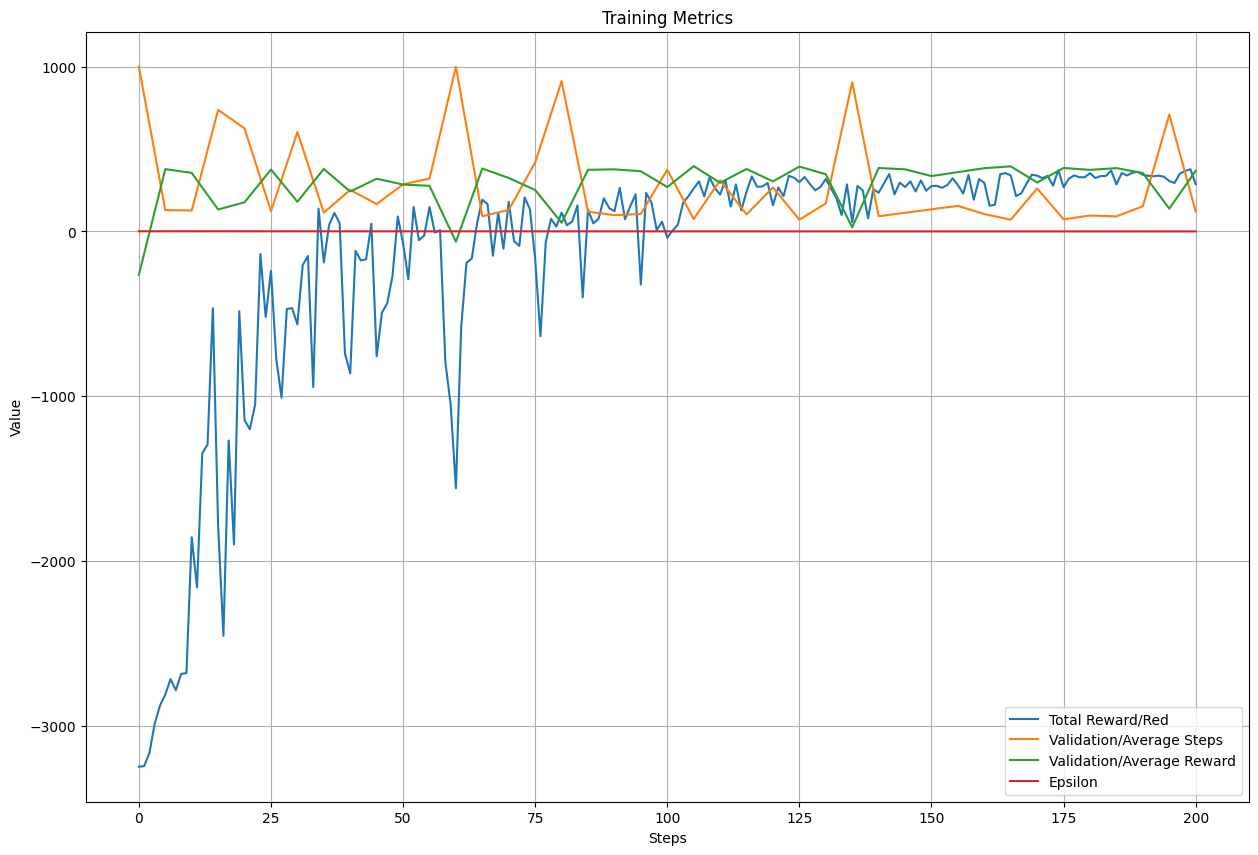

In [14]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# --- Function to extract data from TensorBoard logs ---
def extract_data_from_logs(log_dir, tags):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    data = {tag: [] for tag in tags}

    for tag in tags:
        events = event_acc.Scalars(tag)
        for event in events:
            data[tag].append((event.step, event.value))

    return data

# --- Set log directory ---
log_dir = "/content/runs"  # Replace with the directory where TensorBoard logs are stored
latest_run = max([os.path.join(log_dir, d) for d in os.listdir(log_dir)], key=os.path.getmtime)

# --- Tags to plot ---
tags_to_plot = ['Total Reward/Red','Validation/Average Steps','Validation/Average Reward', 'Epsilon']
data = extract_data_from_logs(latest_run, tags_to_plot)

# --- Plot data ---
plt.figure(figsize=(15, 10))
for tag in tags_to_plot:
    steps, values = zip(*data[tag])
    plt.plot(steps, values, label=tag)

plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Training Metrics")
plt.legend()
plt.grid(True)
plt.show()
